In [1]:
from base64 import b64decode
import requests
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.ML.Cluster import Butina
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

In [2]:
cids = []
with open('Compound_IDs.txt', 'r') as f:
    for line in f:
        cids.append(line[:-1])


In [15]:
df = pd.DataFrame(cids, columns = ['CID'])

In [5]:
prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

# str_cid = ",".join([x[4:] for x in cids[:500]])
str_cid = ",".join([x[4:] for x in cids[500:]])

url = prolog + "/compound/cid/" + str_cid + "/property/isomericsmiles/txt"
res = requests.get(url)
smiles = res.text.split()
# fps = []

In [17]:
df['SMILE'] = smiles

In [19]:
df.to_csv('Smiles_FDA.csv', index = False)

In [22]:
df = pd.read_csv('Smiles_FDA.csv')
df.head()

,CID,SMILE
0,CID_10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...
1,CID_10152654,CC(C)(C[C@@H](C(=O)NC1(CC1)C#N)N[C@@H](C2=CC=C...
2,CID_10184653,CN(C)C/C=C/C(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=C...
3,CID_10206,CN1CCC2=CC3=C(C4=C2[C@@H]1CC5=CC=C(C=C5)OC6=C(...
4,CID_10207,C1=CC2=C(C(=C1)O)C(=O)C3=C(C2=O)C=C(C=C3O)CO


In [6]:
mols = [ Chem.MolFromSmiles(x) for x in smiles ]
fps += [AllChem.GetMorganFingerprintAsBitVect(x,3,nBits=2048) for x in mols ]
#fps += [MACCSkeys.GenMACCSKeys(x) for x in mols ]

In [7]:
len(fps)

933

In [15]:
fingerprints = pd.DataFrame()
for i in range(933):
    fingerprints[cids[i]] = np.array(fps[i])
fingerprints.to_csv('fp_FDA.csv', index = False)

In [8]:
dist = np.zeros(shape = (len(cids), len(cids)))
dist = pd.DataFrame(dist, columns = cids, index = cids)
for i in range(len(fps)):
    for j in range(len(fps)):
        score = DataStructs.FingerprintSimilarity(fps[i], fps[j], metric=DataStructs.TanimotoSimilarity)
        dist.at[cids[i], cids[j]] = score

In [9]:
dist.to_csv('Similarity_mat_FDA.csv', index = False)

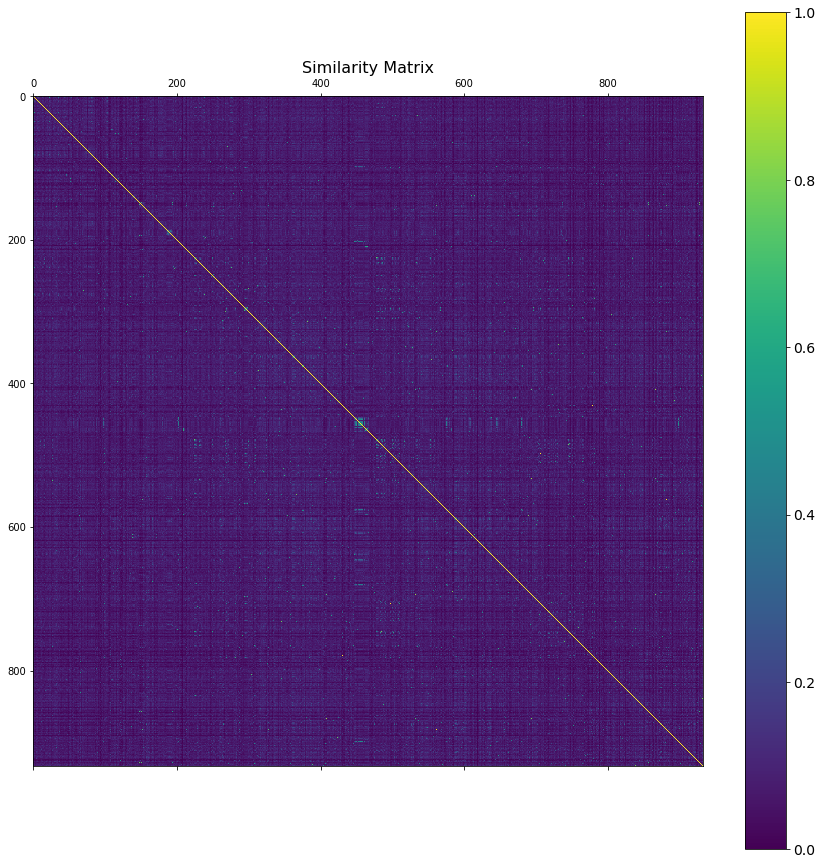

In [9]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15, 15))
plt.matshow(dist, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Similarity Matrix', fontsize=16);

In [9]:
# generate fingerprint matrix for top 2000 cpds
X_arr = np.array( fps, dtype=int )
dists = pdist( X_arr, metric='jaccard' )
# get distance matrix for medoid determination
dist_mat = squareform( dists )


In [10]:
# run HAC
Z = linkage( dists, method='average', optimal_ordering=True )

In [11]:
clusters = fcluster( Z, 0.9, criterion='distance' )
labels = np.unique(clusters).tolist()

In [12]:
for i in range(1,51):
    print(sum(clusters == i))

2
2
5
3
3
89
1
8
6
10
19
1
37
13
11
6
3
3
17
3
5
5
2
1
24
4
58
69
19
162
33
2
59
10
6
33
62
24
25
7
5
40
5
14
2
7
2
2
2
2


In [ ]:
dist = []
nfps = len(fps)
for i in range(1,nfps):
    sims = [DataStructs.FingerprintSimilarity(fps[i],fps[j], metric=DataStructs.DiceSimilarity) for j in range(i)]
    dist.extend([1-x for x in sims])

In [ ]:
cs = Butina.ClusterData(data = dist, nPts = nfps,distThresh = 0.4,isDistData=True)
print(len(cs))